**Pre-defined values from Lunar Time-Transfer paper to define Q and R**

In [39]:
import numpy as np
import math
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458

B_dll = 0.5

s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
pr_var = ((c*T_c)**2)*s_dll

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
prr_var = ((c**2)/((2*pi*f_L1 * T_c)**2)) * (s_pll)


#2 satellites
R = np.array([[pr_var,0,0,0],[0,pr_var,0,0],[0,0,prr_var,0],[0,0,0,prr_var]])

print(R)


[[2.44036996e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.44036996e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.53302279e+09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53302279e+09]]


In [40]:
h_0 = 1.4*(10**(-22))
h_m1 = 2.3*(10**(-26))
h_m2 = 3.3*(10**(-31))

dt = 60

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*((pi*h_m2*dt)**2)*dt
e2 = h_m1*dt + h_m2*(pi*dt)**2
e3 = (h_0/(2*dt))+ 4*h_m1 + (8/3)*(pi*pi)*h_m2*dt

Q = np.array([[e1,e2],[e2,e3]])
print(Q)

[[4.36560000e-21 1.39172509e-24]
 [1.39172509e-24 1.25918778e-24]]


In [41]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

class KalmanFilter(object):
  def __init__(self, A = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):
    if(A is None or H is None):
      raise ValueError("Set proper system dynamics.")

    #Number of state variables
    self.n = A.shape[1]

    #Number of measurement variables
    self.m = H.shape[1]

    self.A = A
    self.H = H
    self.B = np.zeros((1,1)) if B is None else B

    #Covariance is often a diagonal matrix since variables are independent
    self.Q = np.eye(self.n) if Q is None else Q
    self.R = np.eye(self.n) if R is None else R
    self.P = np.eye(self.n) if P is None else P
    self.x = np.zeros((self.n, 1)) if x0 is None else x0

  def predict(self, u = None):
    if u is None: u = np.zeros((self.B.shape[1],1))

    self.x = (self.A @ self.x) + (self.B@ u)
    self.P = ((self.A @self.P)@ self.A.T) + self.Q
    return self.x

  def update(self, z):
    S = self.R + (self.H @ (self.P @ self.H.T)) # in parenthesees of inverse

    #This is a Cholesky Solver which uses the fact that S is symmetric positive definite to solve for K quicker
    #We are solving for K given that S^T * K^T = H * P^T
    K = sp.linalg.cho_solve(sp.linalg.cho_factor(S.T),(self.H @ self.P.T)).T

    #This is the equation for K in the description of the filter for reference
    # K = ((self.P @ self.H.T) @ np.linalg.inv(S))

    y = z - (self.H @ self.x) # in parenthesees of inverse
    self.x = self.x + (K@ y)

    I = np.eye(self.n)
    self.P = (((I-(K@self.H))@ self.P)@((I-(K@self.H)).T))+(K @(self.R @K.T))
    return K

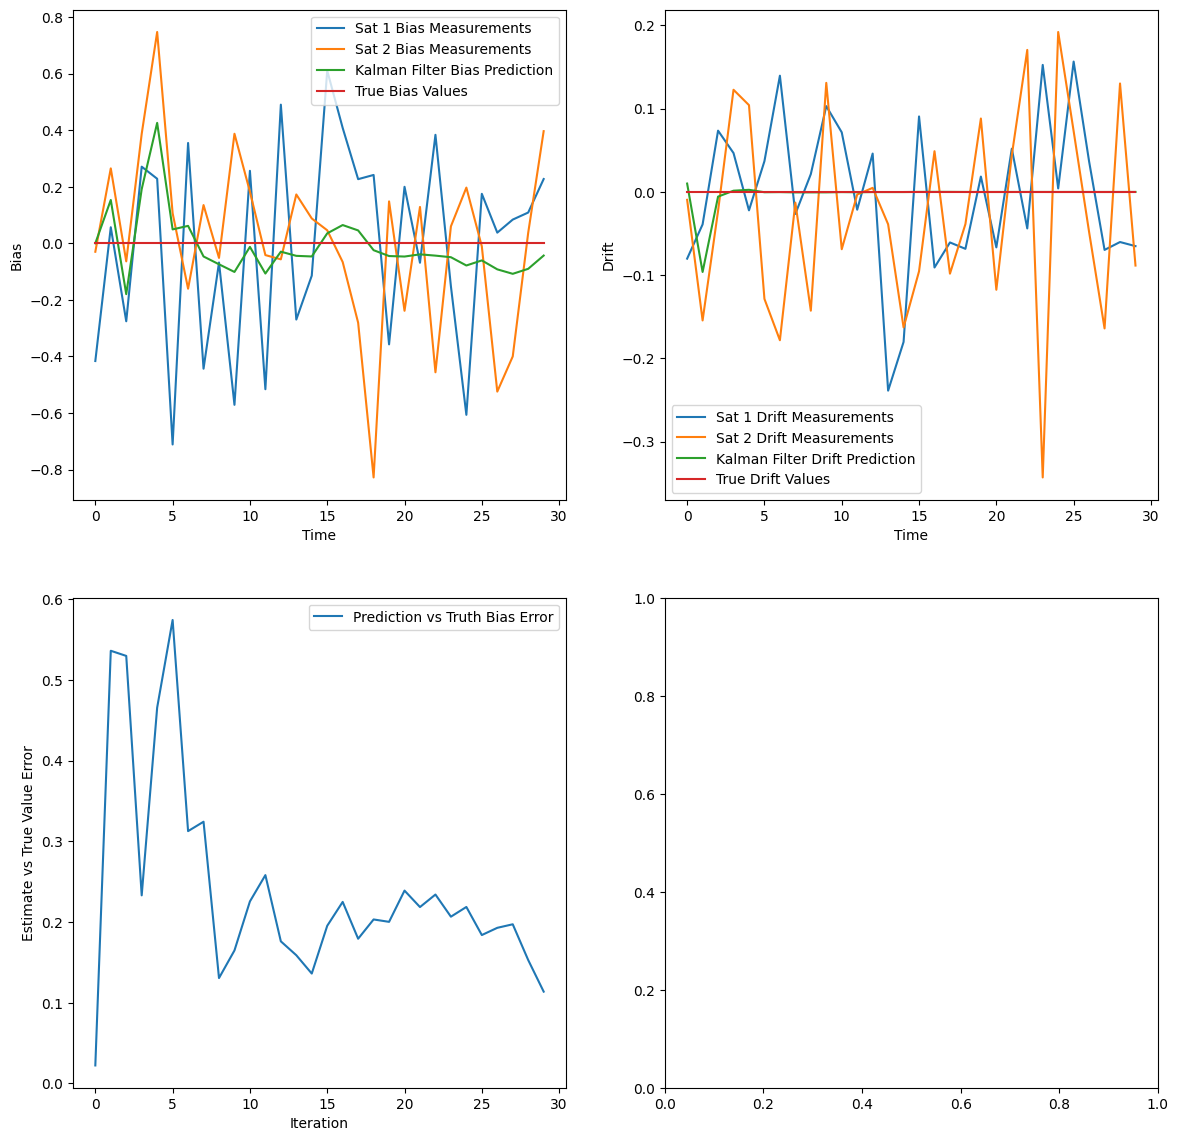

In [65]:
# need to debug this
def example():
    A = np.array([[1, 60, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 60, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 60, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 60, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 60],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

    # set up H
    H = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
    H_20x10 = np.zeros((20, 10))

    for i in range(0, 20, 4):
        H_20x10[i:i+4, i//2:i//2+2] = H

    # defined Q from above
    Q_10x10 = np.zeros((10, 10))

    # Fill the 10x10 matrix with the given 2x2 matrix on the diagonals
    for i in range(0, 10, 2):
        Q_10x10[i:i+2, i:i+2] = Q

    # defined R from above
    R_20x20 = np.zeros((20, 20))

    # Fill the 10x10 matrix with the given 4x4 matrix on the diagonals

    R = np.array([[0.1,0,0,0],[0,0.1,0,0],[0,0,0.01,0],[0,0,0,0.01]])

    for i in range(0, 20, 4):
        R_20x20[i:i+4, i:i+4] = R
    #First Estimate
    x = np.array([[0, 0.01, 0, 0.01, 0, 0.01, 0, 0.01, 0, 0.01]]).T

    #Initial Truth
    x0 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).T


    kf = KalmanFilter(A = A, H = H_20x10, Q = Q_10x10, R = R_20x20, x0 = x)

    procc_noise = lambda : np.linalg.cholesky(Q_10x10) @ np.random.normal(np.array([[0 for _ in range(10)]]).T)
    measure_noise = lambda : np.linalg.cholesky(R_20x20) @ np.random.normal(np.array([[0 for _ in range(20)]]).T)

    z = (H_20x10 @ x0) + measure_noise()

    truth = [x0]
    predictions = [x]
    measurements = [z]
    errors = [(x-x0)]

    for i in range(29):
    
        #Get new truth
        truth.append((A@truth[-1]) + procc_noise())

        #Get new measurements
        z = (H_20x10 @ truth[-1]) + measure_noise()
        measurements.append(z)

        #Correct estimate using measurement
        kf.update(z)
        
        #Record updated estimate and error
        predictions.append(kf.x)

        errors.append(kf.x - truth[-1])

        #Predict next step
        x = kf.predict()

    fig,axs = plt.subplots(2,2, figsize=(14, 14))
    #12 plots, 5 for bias, 5 for drift, and then error
    for i in range(1):
        #20 measurements, 2 for each node
        axs[0][0].plot([i for i in range(30)],[x[4*i][0] for x in measurements], label = 'Sat 1 Bias Measurements')
        axs[0][0].plot([i for i in range(30)],[x[4*i+1][0] for x in measurements], label = 'Sat 2 Bias Measurements')
        axs[0][0].plot([i for i in range(30)],[x[2*i][0] for x in predictions], label = 'Kalman Filter Bias Prediction')
        axs[0][0].plot([i for i in range(30)],[x[2*i][0] for x in truth], label = 'True Bias Values')
        axs[0][0].set_xlabel("Time")
        axs[0][0].set_ylabel("Bias")
        axs[0][0].legend()
        
        axs[0][1].plot([i for i in range(30)],[x[4*i+2][0] for x in measurements], label = 'Sat 1 Drift Measurements')
        axs[0][1].plot([i for i in range(30)],[x[4*i+3][0] for x in measurements], label = 'Sat 2 Drift Measurements')
        axs[0][1].plot([i for i in range(30)],[x[2*i+1][0] for x in predictions], label = 'Kalman Filter Drift Prediction')
        axs[0][1].plot([i for i in range(30)],[x[2*i+1][0] for x in truth], label = 'True Drift Values')
        axs[0][1].set_xlabel("Time")
        axs[0][1].set_ylabel("Drift")
        axs[0][1].legend()

    axs[1][0].plot([i for i in range(len(errors))],[np.linalg.norm(x) for x in errors], label = 'Prediction vs Truth Bias Error')
    
    axs[1][0].legend()
    axs[1][0].set_xlabel("Iteration")
    axs[1][0].set_ylabel("Estimate vs True Value Error")
    plt.show()

if __name__ == '__main__':
    example()